In [78]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [79]:
# Definindo a semente para reprodutibilidade
np.random.seed(42)

# Número de amostras
n_samples = 10000

# Gerando atributos do mapa astral
signos = np.random.randint(1, 13, n_samples)  # Signo solar, 12 signos do zodíaco
lunar = np.random.randint(1, 13, n_samples)   # Signo lunar
ascendente = np.random.randint(1, 13, n_samples)
mercurio = np.random.randint(1, 13, n_samples)
venus = np.random.randint(1, 13, n_samples)
marte = np.random.randint(1, 13, n_samples)
jupiter = np.random.randint(1, 13, n_samples)
saturno = np.random.randint(1, 13, n_samples)
aspectos = np.random.randint(1, 6, n_samples)  # 5 tipos de aspectos planetários

# Introduzindo uma variável resposta com distribuição equilibrada
caloteiro = np.random.randint(0, 2, n_samples)

# Criando uma correlação artificial e progressiva entre os atributos e a variável resposta
# Atributos selecionados para ter uma correlação mais forte: mercurio, venus, aspectos
# Introduzindo uma correlação artificial simples
correlacao_simples = (mercurio + venus + aspectos) % 2

# Introduzindo ruído
ruído = np.random.normal(0, 0.1, n_samples)

# Variável resposta final, considerando o ruído
caloteiro_final = (0.5 * caloteiro + 0.5 * correlacao_simples + ruído) > 0.5
caloteiro_final = caloteiro_final.astype(int)

# Criando o DataFrame
df = pd.DataFrame({
    'SignoSolar': signos,
    'SignoLunar': lunar,
    'Ascendente': ascendente,
    'Mercurio': mercurio,
    'Venus': venus,
    'Marte': marte,
    'Jupiter': jupiter,
    'Saturno': saturno,
    'Aspectos': aspectos,
    'Caloteiro': caloteiro_final
})

df.head()

,SignoSolar,SignoLunar,Ascendente,Mercurio,Venus,Marte,Jupiter,Saturno,Aspectos,Caloteiro
0,7,7,2,8,5,12,6,4,2,1
1,4,9,9,5,10,3,12,4,1,1
2,11,10,2,8,3,10,12,3,4,1
3,8,12,1,5,6,6,7,5,1,0
4,5,2,8,1,3,10,7,5,1,1


In [80]:
# Features
X = df[['SignoSolar', 'SignoLunar', 'Ascendente', 'Mercurio', 'Venus', 'Marte',
       'Jupiter', 'Saturno', 'Aspectos']]
# Target
y = df['Caloteiro']

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np

def calcular_gini(y_test, predicoes):
    return 2 * roc_auc_score(y_test, predicoes) - 1

def calcular_ks(y_test, y_probas):
    fpr, tpr, thresholds = roc_curve(y_test, y_probas)
    ks = max(tpr - fpr)
    return ks

def testar_todos_os_modelos(df):
    # Separando os dados
    X = df.drop('Caloteiro', axis=1)
    y = df['Caloteiro']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Definindo os modelos
    modelos = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'SVC': SVC(probability=True, class_weight='balanced'),
        'LinearSVC': LinearSVC(max_iter=10000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
        'GaussianNB': GaussianNB(),
        'Perceptron': Perceptron(class_weight='balanced', max_iter=1000, tol=1e-3),
        'SGDClassifier': SGDClassifier(class_weight='balanced'),
        'Decision Tree': DecisionTreeClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LGBMClassifier': LGBMClassifier()
    }

    resultados = []

    for nome, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        predicoes = modelo.predict(X_test)
        probas = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else np.nan

        # Calculando métricas
        acuracia = accuracy_score(y_test, predicoes)
        precisao = precision_score(y_test, predicoes, zero_division=0)
        recall = recall_score(y_test, predicoes)
        f1 = f1_score(y_test, predicoes)
        auc = roc_auc_score(y_test, probas) if not np.isnan(probas).all() else np.nan
        gini = calcular_gini(y_test, probas) if not np.isnan(probas).all() else np.nan
        ks = calcular_ks(y_test, probas) if not np.isnan(probas).all() else np.nan

        resultados.append({
            'Modelo': nome,
            'Accuracy': acuracia,
            'Precision': precisao,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'KS': ks,
            'Gini': gini
        })

    # Convertendo resultados em DataFrame para visualização
    resultados_df = pd.DataFrame(resultados)
    return resultados_df

# Substitua 'df' pelo seu DataFrame real
resultados_df = testar_todos_os_modelos(df)
resultados_df.sort_values(by=['Gini', 'Accuracy', 'Precision'], ascending=False).round(4)

[LightGBM] [Info] Number of positive: 4039, number of negative: 3961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504875 -> initscore=0.019501
[LightGBM] [Info] Start training from score 0.019501


,Modelo,Accuracy,Precision,Recall,F1-Score,AUC,KS,Gini
5,GaussianNB,0.5235,0.5188,0.6366,0.5717,0.5312,0.0570,0.0624
9,AdaBoost,0.5235,0.5216,0.5556,0.5381,0.5305,0.0560,0.0611
0,Logistic Regression,0.5225,0.5229,0.5025,0.5125,0.5211,0.0510,0.0423
11,LGBMClassifier,0.5165,0.5152,0.5415,0.5281,0.5160,0.0508,0.0319
3,Random Forest,0.5125,0.5118,0.5195,0.5156,0.5081,0.0250,0.0161
10,XGBoost,0.5125,0.5117,0.5275,0.5195,0.5022,0.0351,0.0043
8,Decision Tree,0.4995,0.4990,0.5005,0.4998,0.4995,0.0000,-0.0010
1,SVC,0.4940,0.4933,0.4815,0.4873,0.4982,0.0138,-0.0035
4,KNN,0.4785,0.4782,0.4825,0.4803,0.4833,0.0076,-0.0335
2,LinearSVC,0.5235,0.5239,0.5055,0.5145,NaN,NaN,NaN


In [82]:
# Para simplificar, vamos considerar o risco com base no signo solar, Mercúrio e Aspectos, de forma totalmente hipotética
df['RiscoDeCredito'] = np.random.choice([0, 1, 2], size=n_samples)

# Etapa 1: Introduzir interações não-lineares
df['Interacao1'] = df['Mercurio'] * df['Venus']
df['Interacao2'] = df['Aspectos'] ** 2

# Etapa 2: Aumentar a complexidade do ruído
# Adicionando ruído variável com base em 'Mercurio' e 'Venus'
ruído_complexo = np.random.normal(0, df['Mercurio'] / df['Venus'], n_samples)

# Reajustando a variável resposta com a nova complexidade
caloteiro_final_complexo = (0.5 * df['Caloteiro'] + 0.3 * correlacao_simples + 0.2 * ruído_complexo) > 0.55
df['Caloteiro'] = caloteiro_final_complexo.astype(int)

# Verifique o balanceamento da nova variável resposta
df['Caloteiro'].value_counts(normalize=True)

0    0.5902
1    0.4098
Name: Caloteiro, dtype: float64

In [83]:
# Features
X = df[['SignoSolar', 'SignoLunar', 'Ascendente', 'Mercurio', 'Venus', 'Marte',
       'Jupiter', 'Saturno', 'Aspectos', 'Interacao1', 'Interacao2']]
# Target
y = df['Caloteiro']

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np

def calcular_gini(y_test, predicoes):
    return 2 * roc_auc_score(y_test, predicoes) - 1

def calcular_ks(y_test, y_probas):
    fpr, tpr, thresholds = roc_curve(y_test, y_probas)
    ks = max(tpr - fpr)
    return ks

def testar_todos_os_modelos(df):
    # Separando os dados
    X = df.drop('Caloteiro', axis=1)
    y = df['Caloteiro']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Definindo os modelos
    modelos = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'SVC': SVC(probability=True, class_weight='balanced'),
        'LinearSVC': LinearSVC(max_iter=10000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
        'GaussianNB': GaussianNB(),
        'Perceptron': Perceptron(class_weight='balanced', max_iter=1000, tol=1e-3),
        'SGDClassifier': SGDClassifier(class_weight='balanced'),
        'Decision Tree': DecisionTreeClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LGBMClassifier': LGBMClassifier()
    }

    resultados = []

    for nome, modelo in modelos.items():
        modelo.fit(X_train, y_train)
        predicoes = modelo.predict(X_test)
        probas = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else np.nan

        # Calculando métricas
        acuracia = accuracy_score(y_test, predicoes)
        precisao = precision_score(y_test, predicoes, zero_division=0)
        recall = recall_score(y_test, predicoes)
        f1 = f1_score(y_test, predicoes)
        auc = roc_auc_score(y_test, probas) if not np.isnan(probas).all() else np.nan
        gini = calcular_gini(y_test, probas) if not np.isnan(probas).all() else np.nan
        ks = calcular_ks(y_test, probas) if not np.isnan(probas).all() else np.nan

        resultados.append({
            'Modelo': nome,
            'Accuracy': acuracia,
            'Precision': precisao,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'KS': ks,
            'Gini': gini
        })

    # Convertendo resultados em DataFrame para visualização
    resultados_df = pd.DataFrame(resultados)
    return resultados_df

# Substitua 'df' pelo seu DataFrame real
resultados_df = testar_todos_os_modelos(df)
resultados_df.sort_values(by=['Gini', 'Accuracy', 'Precision'], ascending=False).round(4)

[LightGBM] [Info] Number of positive: 3285, number of negative: 4715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.410625 -> initscore=-0.361382
[LightGBM] [Info] Start training from score -0.361382


,Modelo,Accuracy,Precision,Recall,F1-Score,AUC,KS,Gini
11,LGBMClassifier,0.5920,0.4959,0.2214,0.3061,0.5892,0.1521,0.1784
10,XGBoost,0.5865,0.4891,0.3862,0.4316,0.5767,0.1350,0.1534
4,KNN,0.5515,0.4379,0.3641,0.3976,0.5443,0.0714,0.0887
3,Random Forest,0.5710,0.4324,0.1771,0.2513,0.5215,0.0417,0.0430
5,GaussianNB,0.5920,0.3636,0.0049,0.0097,0.5186,0.0563,0.0372
0,Logistic Regression,0.5050,0.4100,0.4957,0.4488,0.5124,0.0471,0.0248
9,AdaBoost,0.5855,0.3710,0.0283,0.0526,0.5033,0.0378,0.0067
8,Decision Tree,0.5150,0.4071,0.4231,0.4150,0.5005,0.0011,0.0011
1,SVC,0.5205,0.4011,0.3641,0.3817,0.4987,0.0344,-0.0026
6,Perceptron,0.5935,0.5000,0.0012,0.0025,NaN,NaN,NaN



A análise dos resultados dos diferentes modelos de classificação nesse case revela insights importantes sobre o desempenho de cada algoritmo frente aos dados apresentados. Considerando as características do case, onde foram introduzidas variáveis relacionadas ao mapa astral de indivíduos e uma correlação artificial foi estabelecida para determinar se um indivíduo é caloteiro ou não, aqui está uma avaliação dos modelos:

# **Avaliação Geral**
  *Desbalanceamento de Classes:* A presença de métricas de precisão, recall e F1-Score muito baixas ou nulas para alguns modelos, como o Perceptron, sugere que o desbalanceamento das classes pode estar afetando significativamente o desempenho. O Perceptron, em particular, não conseguiu identificar corretamente nenhuma instância da classe minoritária (caloteiros), como indicado pelos valores zero em precisão e recall.

  *Performance Variável:* Modelos baseados em árvores de decisão, como LGBMClassifier e XGBoost, apresentaram um desempenho relativamente melhor em termos de F1-Score e AUC, indicando uma capacidade superior de lidar com a complexidade e o desbalanceamento dos dados. Esses modelos são conhecidos por sua habilidade em capturar interações não-lineares entre as variáveis.

  *Sensibilidade a Dados Desbalanceados:* Modelos lineares, incluindo Logistic Regression e LinearSVC, mostraram variações significativas em suas métricas de desempenho. O SGDClassifier, em particular, demonstrou uma alta taxa de recall, mas isso veio às custas de uma baixa acurácia, sugerindo uma tendência a prever a classe minoritária na maioria das vezes, o que pode não ser ideal dependendo do contexto específico.

# **Interpretação dos Resultados**
  *LGBMClassifier e XGBoost:* Estes modelos conseguiram um equilíbrio razoável entre as métricas avaliadas, indicando sua eficácia em lidar com os padrões complexos nos dados. A maior AUC e Gini desses modelos sugerem uma capacidade robusta de distinguir entre as classes.

  *KNN e GaussianNB:* Apresentaram performances intermediárias, com o KNN mostrando um equilíbrio entre precisão e recall. O GaussianNB teve uma precisão relativamente boa, mas um recall extremamente baixo, indicando uma dificuldade em identificar a classe minoritária.

  *Random Forest e Logistic Regression:* Tiveram desempenhos modestos, com o Random Forest apresentando um melhor equilíbrio entre precisão e recall do que a Regressão Logística. No entanto, a Regressão Logística mostrou uma capacidade razoável de prever a classe minoritária, como evidenciado pelo recall mais alto.

  *AdaBoost, SVC e Decision Tree:* Demonstraram dificuldades em equilibrar precisão e recall, com performances gerais inferiores aos melhores modelos. Isso pode ser atribuído à natureza dos dados e à maneira como as interações entre as variáveis foram modeladas.

  *LinearSVC e Perceptron:* Ambos mostraram limitações significativas, com o Perceptron falhando completamente em identificar a classe minoritária. O LinearSVC mostrou uma precisão relativamente alta, mas um recall muito baixo, indicando uma tendência a prever a classe majoritária.

  *SGDClassifier:* Apresentou um recall extremamente alto, sugerindo uma predisposição a classificar muitos exemplos como pertencentes à classe minoritária, o que resultou em uma acurácia baixa.

[LightGBM] [Info] Number of positive: 3285, number of negative: 4715
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.410625 -> initscore=-0.361382
[LightGBM] [Info] Start training from score -0.361382


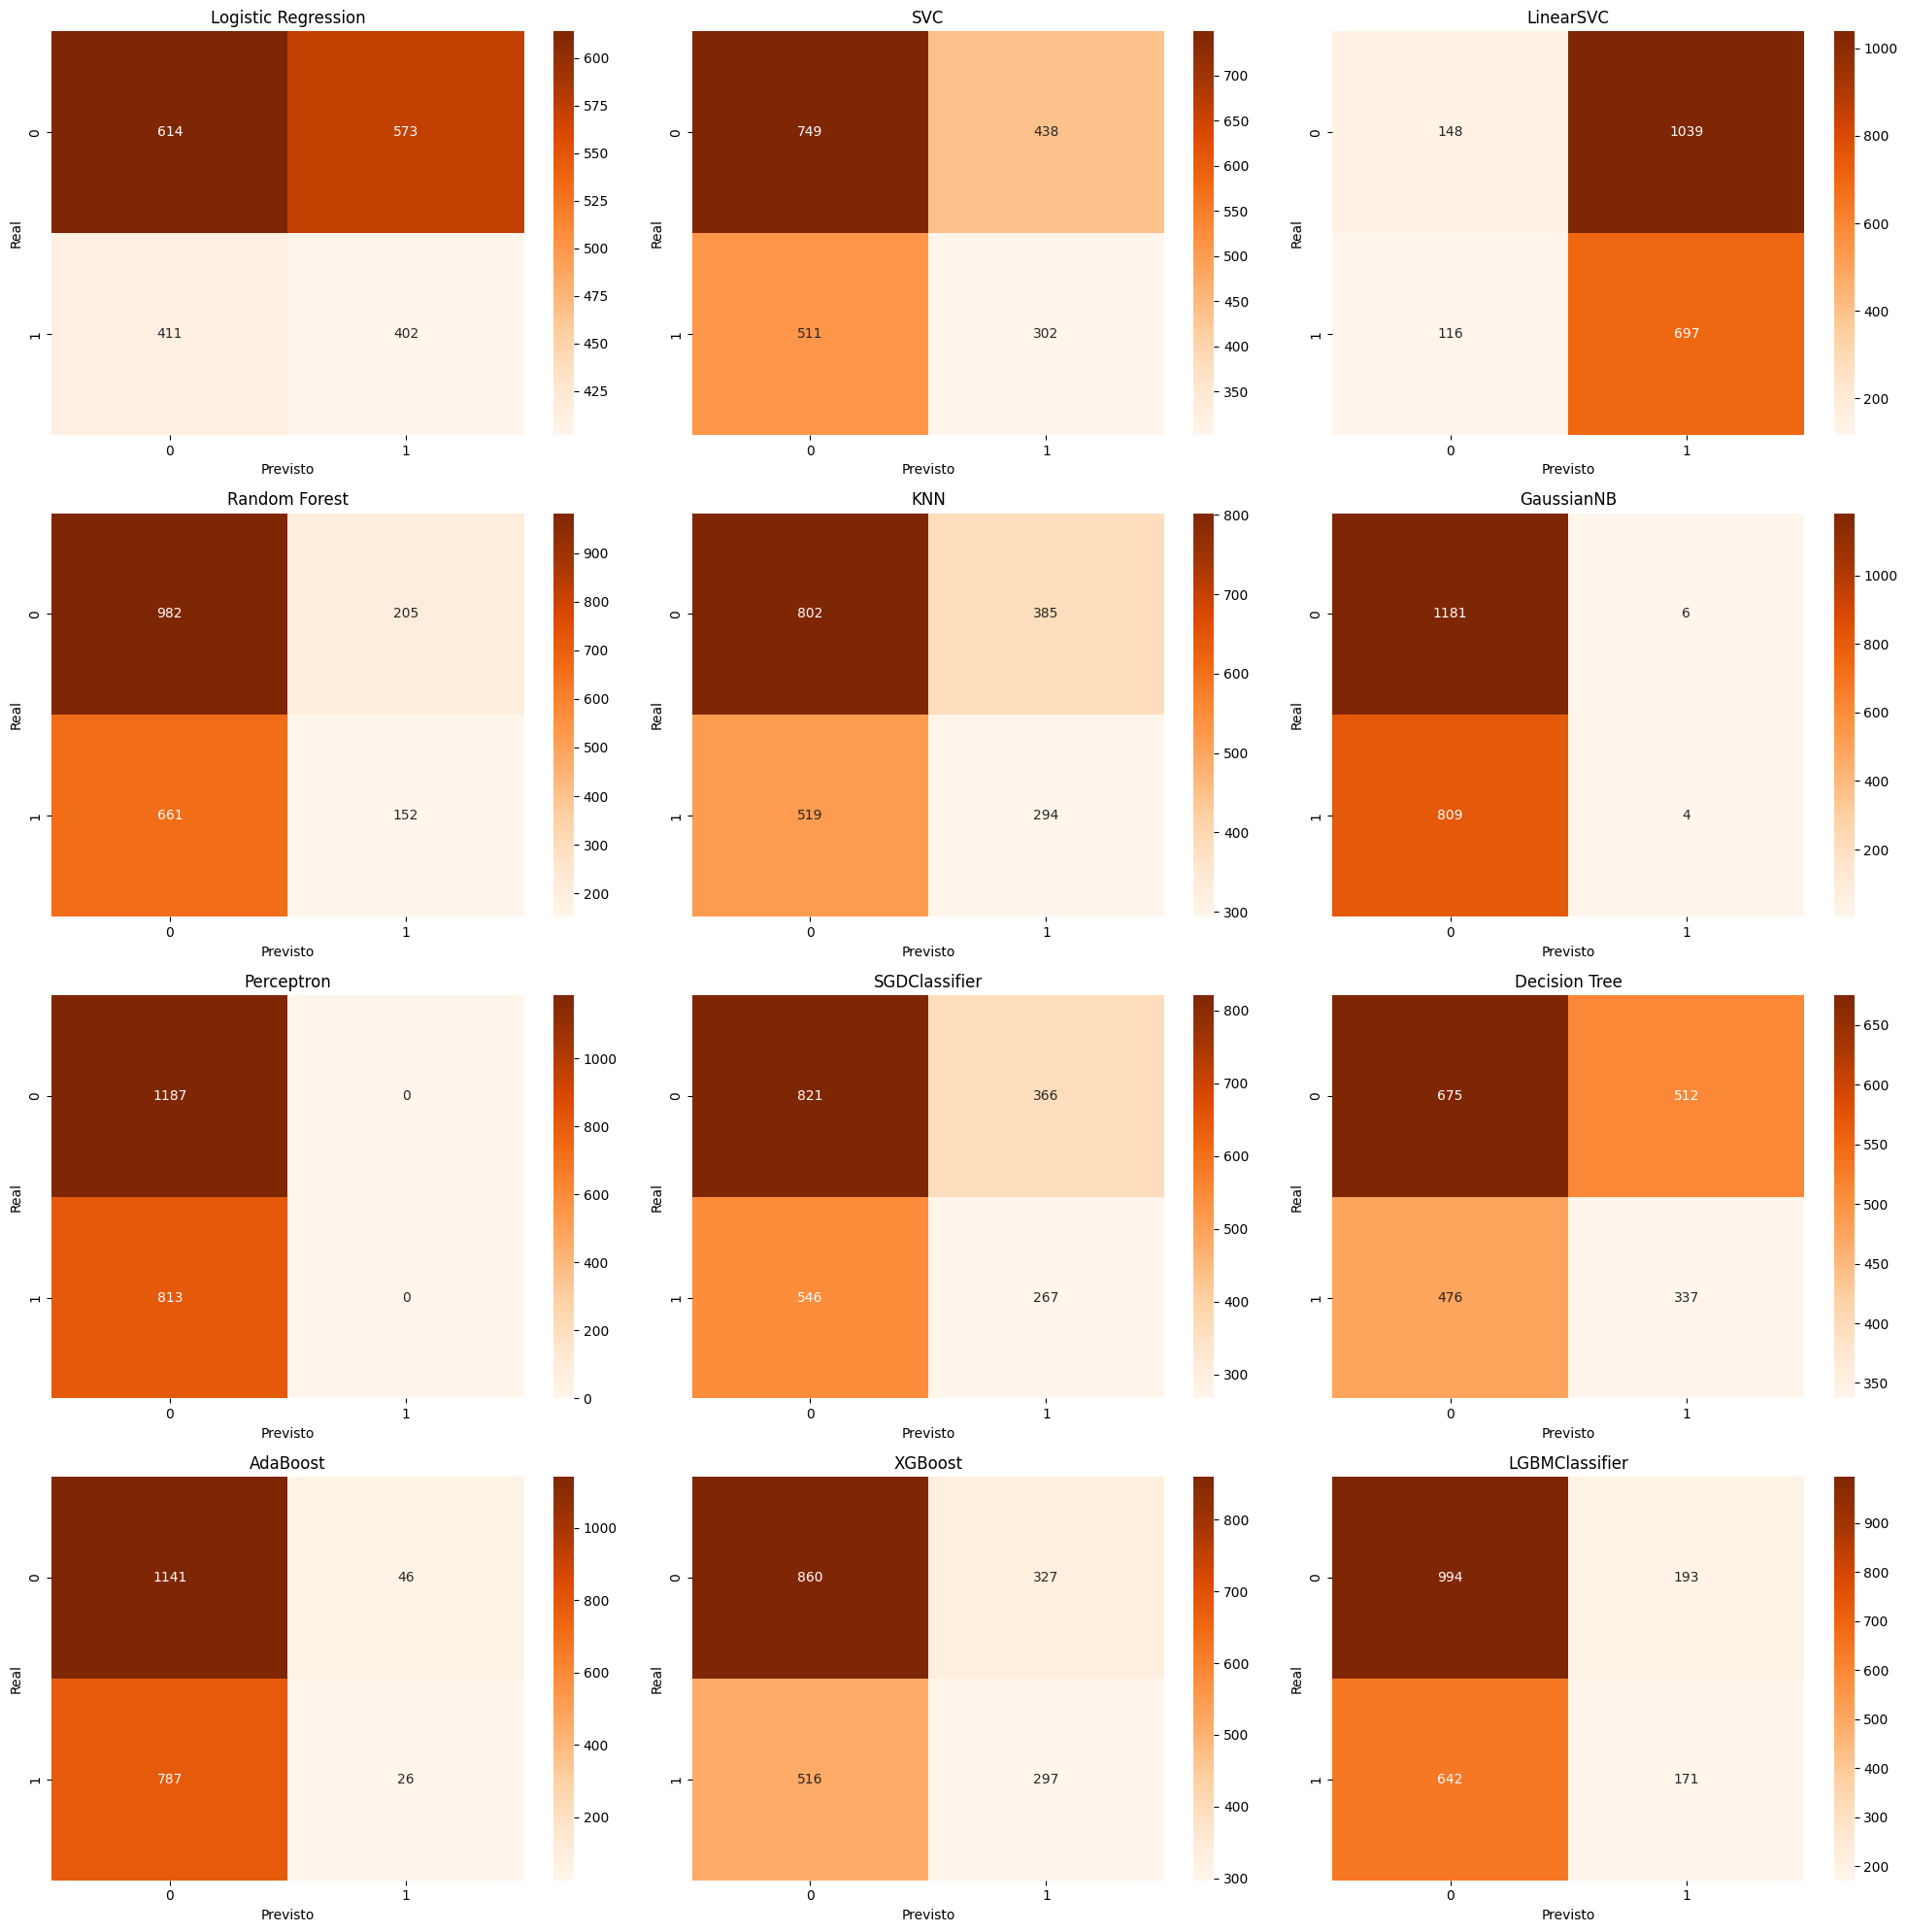

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Supondo que 'df' seja o seu DataFrame e 'X' e 'y' sejam definidos como abaixo
X = df[['SignoSolar', 'SignoLunar', 'Ascendente', 'Mercurio', 'Venus', 'Marte', 'Jupiter', 'Saturno', 'Aspectos', 'Interacao1', 'Interacao2']]
y = df['Caloteiro']

# Divisão dos dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Agora defina a função sem a divisão de dados internamente
def exibir_matrizes_confusao(X_test, y_test):
    # Definindo os modelos
    modelos = {
        'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'SVC': SVC(probability=True, class_weight='balanced'),
        'LinearSVC': LinearSVC(max_iter=10000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
        'GaussianNB': GaussianNB(),
        'Perceptron': Perceptron(class_weight='balanced', max_iter=1000, tol=1e-3),
        'SGDClassifier': SGDClassifier(class_weight='balanced'),
        'Decision Tree': DecisionTreeClassifier(),
        'AdaBoost': AdaBoostClassifier(),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'LGBMClassifier': LGBMClassifier()
    }

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
    axes = axes.flatten()

    for i, (nome, modelo) in enumerate(modelos.items()):
        modelo.fit(X_train, y_train)
        predicoes = modelo.predict(X_test)

        cm = confusion_matrix(y_test, predicoes)
        sns.heatmap(cm, annot=True, fmt="d", ax=axes[i], cmap="Oranges")
        axes[i].set_title(nome)
        axes[i].set_xlabel('Previsto')
        axes[i].set_ylabel('Real')

    plt.tight_layout()
    plt.show()

# Exibe as matrizes de confusão para todos os modelos
exibir_matrizes_confusao(X_test, y_test)
